# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

# Load Data and Preprocessing

In [3]:
from loadAndPreprocess import load_and_preprocess

'''
well_info: Well, X, Y, Total Resources
sensor_data: Depth, Porosity, Hydrate Saturation, Estimated Resources
'''
well_info, sensor_data_list = load_and_preprocess()

# Remove the data point with NaN value
well_info = well_info.dropna()
for sensor_data in sensor_data_list:
    sensor_data.dropna(inplace=True)

# Kriging 3D Interpolation

### Define Functions

In [4]:
def compose_krige3D(name: str, sample_frac: float, step_sizes: tuple, variogram: str):
    from pykrige.ok3d import OrdinaryKriging3D

    # Make kriging interpolation for Porosity  individually
    data_frames = []
    for i, df in enumerate(sensor_data_list):
        df['X'] = well_info.loc[i, 'X']
        df['Y'] = well_info.loc[i, 'Y']
        df['Well'] = well_info.loc[i, 'Well']
        df['Total Resources'] = well_info.loc[i, 'Total Resources']
        data_frames.append(df)

    combined_data = pd.concat(data_frames, ignore_index=True)

    sampled_data = combined_data.sample(frac=sample_frac, random_state=1)  # random_state for reproducibility

    X = sampled_data['X'].values
    Y = sampled_data['Y'].values
    Z = sampled_data['Depth'].values
    values = sampled_data[name].values

    # Create the 3D Kriging model
    ok3d = OrdinaryKriging3D(
        X,
        Y,
        Z,
        values,
        variogram_model=variogram,  # You might need to experiment with different models
        verbose=True,
        enable_plotting=True,
    )
    
    # Define grid points for interpolation
    grid_x = np.arange(min(X)-200, max(X)+200, step_sizes[0])
    grid_y = np.arange(min(Y)-200, max(Y)+200, step_sizes[1])
    grid_z = np.arange(min(Z)-1, max(Z)+1, step_sizes[2])

    return ok3d, (grid_x, grid_y, grid_z)

In [5]:
def plot_3D_mesh(t, grid_x, grid_y, grid_z, title: str):
    GZ, GY, GX = np.meshgrid(grid_z, grid_y, grid_x, indexing='ij')
    print(GX.shape, GY.shape, GZ.shape)  # 应该输出 (12, 108, 88) 或类似，取决于具体的 grid_x, grid_y, grid_z

    fig = go.Figure(
        data=[go.Volume(
            x=GX.flatten(),
            y=GY.flatten(),
            z=GZ.flatten(),
            value=t.flatten(),
            isomin=t.min(),
            isomax=t.max(),
            opacity=0.5,  # Adjust the opacity to your liking
            surface_count=15,  # Adjust the number of isosurfaces
        )])

    # Update the layout of the plot
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis=dict(
                title='Depth',
                autorange='reversed'  # Automatically reverse the z-axis
            )
        )
    )

    # Show the plot
    fig.show()

### Kriging Interpolation of Porosity

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'hole-effect' Variogram Model
Partial Sill: 0.0009267883660267612
Full Sill: 0.00679103475176719
Range: 1589.740318338062
Nugget: 0.005864246385740428 



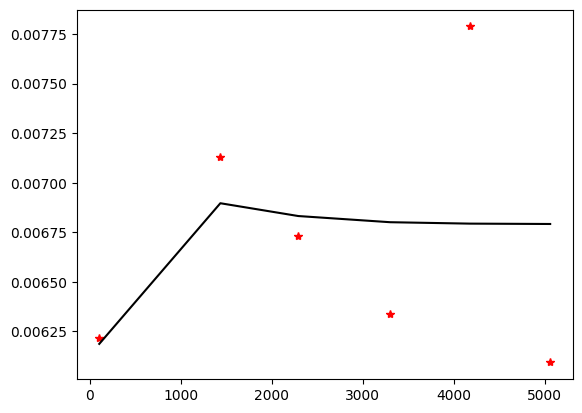

Calculating statistics on variogram model fit...
Q1 = 0.0029445147838970025
Q2 = 0.673665749215307
cR = 0.004090828660354379 



In [13]:
ok3d, grid = compose_krige3D("Porosity", 0.2, (10, 10, 1), 'hole-effect')

In [ ]:
t_poro, ss3d_poro = ok3d.execute('grid', *grid)

Executing Ordinary Kriging...



MemoryError: Unable to allocate 2.61 TiB for an array with shape (133531200, 2687) and data type float64

In [ ]:
plot_3D_mesh(t_poro, *grid, "Kriging Interpolation of Porosity")

In [ ]:
plot_3D_mesh(ss3d_poro, *grid, "Kriging Varience of Porosity")

### Kriging Interpolation of Hydrate Saturation

In [ ]:
ok3d, grid = compose_krige3D("Hydrate Saturation", 0.2, (10, 10, 1), 'linear')

In [ ]:
t_hydr, ss3d_hydr = ok3d.execute('grid', *grid)

In [ ]:
plot_3D_mesh(t_hydr, *grid, "Kriging Interpolation of Hydrate Saturation")

In [ ]:
plot_3D_mesh(ss3d_hydr, *grid, "Kriging Varience of Hydrate Saturation")